# Import & Install 

In [1]:
# GPU 확인 
!nvidia-smi

Thu Aug 31 00:47:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import seaborn as sns
import re

from transformers import BertTokenizer, BertForSequenceClassification
import torch

import os
import math
import random
from typing import Optional, Sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, f1_score

import torch.nn as nn
from transformers import AutoModel, AutoConfig

from tqdm import tqdm
from torch import nn
from torch import Tensor
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback, AutoModel, AutoConfig

import gc
import json
import tensorflow
import matplotlib

import requests
import tarfile

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm.notebook import tqdm    # Process 과정을 보기 위해

from tqdm import tqdm    
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

from konlpy.tag import Mecab
import sentencepiece as spm

from transformers import ElectraTokenizer, ElectraForSequenceClassification

from collections import Counter
from konlpy.tag import Mecab
from soynlp.normalizer import *


## 0) Data Load

In [112]:
train_data_path ="/aiffel/aiffel/dktc/data/train.csv"
train = pd.read_csv(train_data_path)

test_data_path ="/aiffel/aiffel/dktc/data/test.json"
with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)
test = pd.DataFrame({'file_name':list(test.keys()),'conversation':[list(test.values())[i]['text'] for i in range(len(list(test.values())))] })

train.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [113]:
train

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [114]:
def split_users(x):
    x = x.split('\n')
    userA = x[::2]
    userB = x[1::2]
    return pd.Series(['\n'.join(userA), '\n'.join(userB)], index=['A', 'B'])

train[['A', 'B']] = train['conversation'].apply(split_users)

In [115]:
def preprocess_sentence(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣?.!,])', " ", sentence)
    sentence = re.sub(r'!+', '!', sentence)
    sentence = re.sub(r'\?+', '?', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence


In [116]:
train['A'] = train['A'].apply(preprocess_sentence)
train['B'] = train['B'].apply(preprocess_sentence)

In [117]:
train['A_length'] = train['A'].apply(len)
train['B_length'] = train['B'].apply(len)

train['A_B_Gap'] = train[['A_length','B_length']].apply(lambda x : x[0]-x[1],axis=1)

def selected_conversation(x):
    c, a , b  = x[0] , x[1] , x[2]
    if len(a) > len(b):
        return a
    elif len(a) < len(b):
        return b
    else:
        return c 

train['con'] = train[['conversation','A','B']].apply(selected_conversation,axis=1)

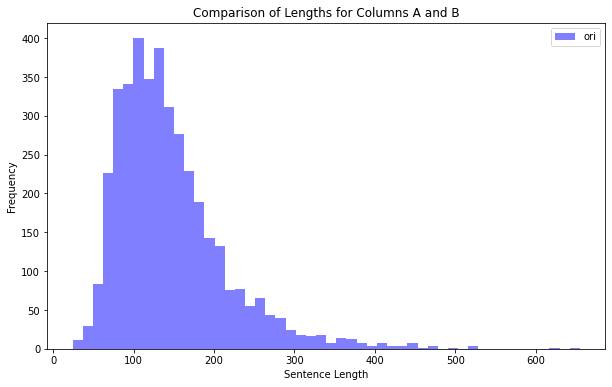

In [118]:
# 플롯 생성
plt.figure(figsize=(10, 6))
plt.hist(train['con'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
# plt.hist(train['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='select')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

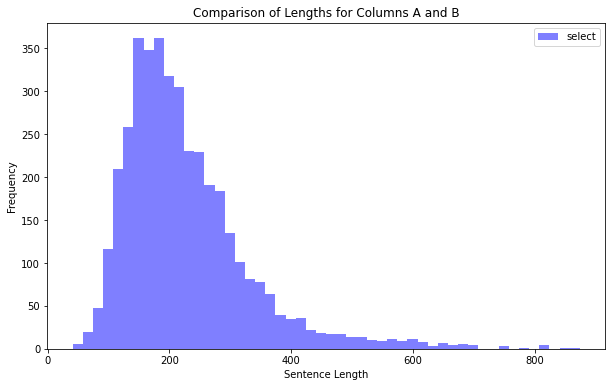

In [119]:
# 플롯 생성
plt.figure(figsize=(10, 6))
# plt.hist(train['con'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
plt.hist(train['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='select')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [120]:
# train['conversation'] = train['conversation'].apply(preprocess_sentence)
train.head()

,idx,class,conversation,A,B,A_length,B_length,A_B_Gap,con
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 죽을 거면 혼자 죽지 우리까지 사건...,아닙니다 . 죄송합니다 . 정말 잘못했습니다 . 죄송합니다 . 정말 잘못했습니다 ....,168,81,87,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 죽을 거면 혼자 죽지 우리까지 사건...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 . 네 ? 장난전화 걸지 마시죠 . 장난전화는 업무방해죄에 해당됩니...,시 분 마트에 폭발물을 설치할거다 . 똑바로 들어 한번만 더 얘기한다 . 시 분 마...,61,130,-69,시 분 마트에 폭발물을 설치할거다 . 똑바로 들어 한번만 더 얘기한다 . 시 분 마...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 지영아 너가 키 이지 ? ...,그만해 . 니들 놀리는거 재미없어 . 너 군대도 안가고 좋겠다 . 난쟁이들도 장가가...,113,111,2,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 지영아 너가 키 이지 ? ...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 너 말이야 너 . 이리 오라고 너 옷 좋아보인다 ? 아니에요 . 돈 없어...,예 ? 무슨 일 . 얘 돈 좀 있나봐 뒤져서 나오면 넌 죽는다 콜 . 마지막 기회다...,65,57,8,어이 거기 너 말이야 너 . 이리 오라고 너 옷 좋아보인다 ? 아니에요 . 돈 없어...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,아 진짜요 ? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요 ! 음...,235,246,-11,아 진짜요 ? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요 ! 음...


In [124]:
train[train['class']==k]

,idx,class,conversation,A,B,A_length,B_length,A_B_Gap,con
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 지영아 너가 키 이지 ? ...,그만해 . 니들 놀리는거 재미없어 . 너 군대도 안가고 좋겠다 . 난쟁이들도 장가가...,113,111,2,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 지영아 너가 키 이지 ? ...
6,6,기타 괴롭힘 대화,35번 손님 아이스커피 두잔나왔습니다\n아이스커피? \n네 맛있게드세요\n저기요 아...,번 손님 아이스커피 두잔나왔습니다 네 맛있게드세요 아 분명 오늘 날이 더우시다고 아...,아이스커피 ? 저기요 아가씨 나는 아아스 시킨적이 없는데 ? 내가 그랫어 ? 아그런...,105,138,-33,아이스커피 ? 저기요 아가씨 나는 아아스 시킨적이 없는데 ? 내가 그랫어 ? 아그런...
7,7,기타 괴롭힘 대화,경비아저씨 내차에 경고장 붙였어요?\n내가 여기 몇년째 사는데 아직도 내차인줄 모르...,경비아저씨 내차에 경고장 붙였어요 ? 입주민께서 정해진 주차자리가 아닌 통로에 계속...,내가 여기 몇년째 사는데 아직도 내차인줄 모르고 이딴식으로 경고장을 붙여 ? 내가 ...,225,153,72,경비아저씨 내차에 경고장 붙였어요 ? 입주민께서 정해진 주차자리가 아닌 통로에 계속...
8,8,기타 괴롭힘 대화,이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 ...,이거 할인 된다면서요 아까 저 시람은 할인 해주던데 고객을 차별하는 거에요 ? 점장...,확인해보겠습니다 네 저 손님은 고객님이십니다 저희는 등급제로 운영돼서 그런겁니다 손...,63,78,-15,확인해보겠습니다 네 저 손님은 고객님이십니다 저희는 등급제로 운영돼서 그런겁니다 손...
18,18,기타 괴롭힘 대화,야 너이마빡에 빛이난다\n어?\n야 한대만 때려보자 퍽\n아 흑 왜그래 \n아팠어?...,야 너이마빡에 빛이난다 야 한대만 때려보자 퍽 아팠어 ? 빛이나길래 두드려봤다 가만...,어 ? 아 흑 왜그래 뭔소리야 저리치워 야 너 미쳤어 ? 흑흑흑,119,35,84,야 너이마빡에 빛이난다 야 한대만 때려보자 퍽 아팠어 ? 빛이나길래 두드려봤다 가만...
...,...,...,...,...,...,...,...,...,...
3935,3935,기타 괴롭힘 대화,너는 이걸 그림이라고 그렸니?\n이리 줘!\n진짜 손재주라고는 전혀 없다.\n응 점...,너는 이걸 그림이라고 그렸니 ? 진짜 손재주라고는 전혀 없다 . 놀리지마 . 무슨 ...,이리 줘 ! 응 점수 빵점이겠다 너 . 어 ? 울어 ? 이걸로 ? 너는 나이를 어디...,65,67,-2,이리 줘 ! 응 점수 빵점이겠다 너 . 어 ? 울어 ? 이걸로 ? 너는 나이를 어디...
3936,3936,기타 괴롭힘 대화,엄마 제가 물건 놔뒀는데 치웠어요\n아니 안 치웠는데\n제가 물건 여기 놔뒀는데 없...,엄마 제가 물건 놔뒀는데 치웠어요 제가 물건 여기 놔뒀는데 없는데요 엄마 말고는 버...,아니 안 치웠는데 안 치었니까 찾으면 어떡할래 혹시 비닐봉지 말하는 거야 그거 쓰레...,88,59,29,엄마 제가 물건 놔뒀는데 치웠어요 제가 물건 여기 놔뒀는데 없는데요 엄마 말고는 버...
3940,3940,기타 괴롭힘 대화,애들아 공연 연습하자.\n이번주에 최종 평가 있어. 빨리 하자.\n야 김정미 너는 ...,애들아 공연 연습하자 . 야 김정미 너는 왜 맨날 이 부분에서 틀려 ? 너 때문에 ...,이번주에 최종 평가 있어 . 빨리 하자 . 어 . 미안해 내가 더 연습해야 했는데 ...,158,82,76,애들아 공연 연습하자 . 야 김정미 너는 왜 맨날 이 부분에서 틀려 ? 너 때문에 ...
3944,3944,기타 괴롭힘 대화,나를 왜 자꾸 때려\n때리고 싶으니깐.\n내가 뭐 잘못했어?\n아니 잘못없지\n근데...,나를 왜 자꾸 때려 내가 뭐 잘못했어 ? 근데 왜 ? 왜 나쁜데 그럼 어떡해야해 ?,때리고 싶으니깐 . 아니 잘못없지 너만보면 기분이 나쁘니깐 쳐다보는게 기분나쁘다 그...,46,57,-11,때리고 싶으니깐 . 아니 잘못없지 너만보면 기분이 나쁘니깐 쳐다보는게 기분나쁘다 그...


In [125]:
for k in list(train['class'].value_counts().index) :
    print(f'[{k}]')
    for i, (a,b) in enumerate(zip(train[train['class']==k]['A'],train[train['class']==k]['B'])):
        print('[원본]')
        print('\t', train[train['class']==k].reset_index().loc[i,'conversation'])
        if len(a) > len(b):
            print('[가해자] :')
            print('\t',a)
            print('[피해자] :')
            print('\t',b)
        elif len(a) < len(b):
            print('[가해자] :')
            print('\t',b)
            print('[피해자] :')
            print('\t',a)
        else:
            print('[알수없음] :')
            print('\t',a)
            print('[알수없음] :')
            print('\t',b)
        print('-'*70)
        if i > 10:
            break
    print('-'*70)
    print('-'*70)
    print('-'*70)

[기타 괴롭힘 대화]
[원본]
	 너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.
그만해. 니들 놀리는거 재미없어.
지영아 너가 키 160이지? 그럼 재는 160도 안돼는거네?
너 군대도 안가고 좋겠다.
니들이 나 작은데 보태준거 있냐?
난쟁이들도 장가가고하던데. 너도 희망을 가져봐 
더이상 하지마라. 
그 키크는 수술도 있대잖아? 니네 엄마는 그거 안해주디?
나람 해줬어. 저 키로 어찌살아.
제발 그만 괴롭히라고!
[가해자] :
	 너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 지영아 너가 키 이지 ? 그럼 재는 도 안돼는거네 ? 니들이 나 작은데 보태준거 있냐 ? 더이상 하지마라 . 나람 해줬어 . 저 키로 어찌살아 .
[피해자] :
	 그만해 . 니들 놀리는거 재미없어 . 너 군대도 안가고 좋겠다 . 난쟁이들도 장가가고하던데 . 너도 희망을 가져봐 그 키크는 수술도 있대잖아 ? 니네 엄마는 그거 안해주디 ? 제발 그만 괴롭히라고 !
----------------------------------------------------------------------
[원본]
	 35번 손님 아이스커피 두잔나왔습니다
아이스커피? 
네 맛있게드세요
저기요 아가씨 나는 아아스 시킨적이 없는데?
아 분명 오늘 날이 더우시다고 아이스로 시키셨는데요
내가 그랫어? 
네분명히.
아그런 기억이 없는데? 아가씨가잘못안거 아니야?
아니요. 오늘 손님이 첫 주문이라 확실히 기억하고 있습니다
아가씨. 왜이렇게 유도리가 없이 굴어 그냥 아 제가 잘못 주문 받았습니다 하면 되지?
.네?.
어휴 유도리 없어 그냥 마실게
[가해자] :
	 아이스커피 ? 저기요 아가씨 나는 아아스 시킨적이 없는데 ? 내가 그랫어 ? 아그런 기억이 없는데 ? 아가씨가잘못안거 아니야 ? 아가씨 . 왜이렇게 유도리가 없이 굴어 그냥 아 제가 잘못 주문 받았습니다 하면 되지 ? 어휴 유도리 없어 그냥 마실게
[피해자] :
	 번 손님 아이스커피 두잔나왔습니다 네 맛있게드세요 아 분명 오늘 날이 더우시

In [89]:
train.iloc[8,2]

'이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 저 손님은 고객님이십니다\n 고객을 차별하는 거에요?\n 저희는 등급제로 운영돼서 그런겁니다\n 점장 불러오세요\n 손님 이건 점장님도 해결해주시지 못합니다\n 그니까 점장 불러와\n 진정을 좀 해보세요'

In [126]:
train.head()

,idx,class,conversation,A,B,A_length,B_length,A_B_Gap,con
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 죽을 거면 혼자 죽지 우리까지 사건...,아닙니다 . 죄송합니다 . 정말 잘못했습니다 . 죄송합니다 . 정말 잘못했습니다 ....,168,81,87,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 죽을 거면 혼자 죽지 우리까지 사건...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 . 네 ? 장난전화 걸지 마시죠 . 장난전화는 업무방해죄에 해당됩니...,시 분 마트에 폭발물을 설치할거다 . 똑바로 들어 한번만 더 얘기한다 . 시 분 마...,61,130,-69,시 분 마트에 폭발물을 설치할거다 . 똑바로 들어 한번만 더 얘기한다 . 시 분 마...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 지영아 너가 키 이지 ? ...,그만해 . 니들 놀리는거 재미없어 . 너 군대도 안가고 좋겠다 . 난쟁이들도 장가가...,113,111,2,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 지영아 너가 키 이지 ? ...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 너 말이야 너 . 이리 오라고 너 옷 좋아보인다 ? 아니에요 . 돈 없어...,예 ? 무슨 일 . 얘 돈 좀 있나봐 뒤져서 나오면 넌 죽는다 콜 . 마지막 기회다...,65,57,8,어이 거기 너 말이야 너 . 이리 오라고 너 옷 좋아보인다 ? 아니에요 . 돈 없어...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,아 진짜요 ? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요 ! 음...,235,246,-11,아 진짜요 ? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요 ! 음...


In [139]:
for k, txt in enumerate(train['conversation']):
    for i, text in enumerate(txt.split('\n')):
        if i % 2 == 0 :
            print('A :', text)
        else:
            print('B :', text)
    
    if k > 10 :
        break
    print('-'*70)
    print('-'*70)
    print('-'*70)

A : 지금 너 스스로를 죽여달라고 애원하는 것인가?
B :  아닙니다. 죄송합니다.
A :  죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.
B :  정말 잘못했습니다.
A :  너가 선택해. 너가 죽을래 네 가족을 죽여줄까.
B :  죄송합니다. 정말 잘못했습니다.
A :  너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.
B :  선택 못하겠습니다. 한번만 도와주세요.
A :  그냥 다 죽여버려야겠군. 이의 없지?
B :  제발 도와주세요.
----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------
A : 길동경찰서입니다.
B : 9시 40분 마트에 폭발물을 설치할거다.
A : 네?
B : 똑바로 들어 한번만 더 얘기한다.
A : 장난전화 걸지 마시죠. 
B : 9시 40분 마트에 폭발물이 터지면 다 죽는거야. 
A : 장난전화는 업무방해죄에 해당됩니다.
B : 판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지.
A : 선생님 진정하세요.
B : 난 이야기했어. 경고했다는 말이야.
----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------
A : 너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.
B : 그만해. 니들 놀리는거 재미없어.
A : 지

# OpenAI API - 가해자, 피해자 나누기

## 가설 : 가해자의 대화만 사용하면 성능이 향상될 것이다

1. openai api를 이용해서 가해자, 피해자 분류하기
2. 가해자 대화만 사용 

In [141]:
!pip install -q openai

     |████████████████████████████████| 76 kB 3.8 MB/s             


### 데이터 로드

In [257]:
train_data_path ="/aiffel/aiffel/dktc/data/train.csv"
train = pd.read_csv(train_data_path)

test_data_path ="/aiffel/aiffel/dktc/data/test.json"
with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)
test = pd.DataFrame({'file_name':list(test.keys()),'conversation':[list(test.values())[i]['text'] for i in range(len(list(test.values())))] })

train.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


### 유저 A B 분리

In [258]:
def add_content(x):
    xx = ''
    for i, text in enumerate(x.split('\n')):
        if i % 2 == 0:
            xx += f'A:{text.strip()}\n'
        else:
            xx += f'B:{text.strip()}\n'
    return xx

train['conversation2'] = train['conversation'].apply(add_content)
train.head()

,idx,class,conversation,conversation2
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,A:지금 너 스스로를 죽여달라고 애원하는 것인가?\nB:아닙니다. 죄송합니다.\nA...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,A:길동경찰서입니다.\nB:9시 40분 마트에 폭발물을 설치할거다.\nA:네?\nB...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,A:너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\nB:그만해. 니들 놀리는...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,A:어이 거기\nB:예??\nA:너 말이야 너. 이리 오라고\nB:무슨 일.\nA:...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,A:저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등...


### OpenAI API

In [259]:
import os
import openai
import time
def request_openai(message):

    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
        {
          "role": "system",
          "content": "Based on the message, you can see who is the perpetrator between A and B. If the perpetrator is ambiguous, please let me know as unknown. The output format is, for example, json. {'Perpetrator': A, 'Victim: B}."
        },
        {
          "role": "user",
          "content": f'{message}',
        }
      ],
    )
    return response["choices"][0]["message"]["content"]

In [251]:
train_dict = dict()

In [294]:
# for idx in train['idx']:
#     if idx < 3480 :
#         continue
#     time.sleep(0.2)
#     if idx % 10 == 0:
#         print(idx)
#     try :
#         train_dict[idx] = request_openai(train.loc[idx,'conversation2'])
#     except Exception as error:  # 예외 처리 시 Exception을 명시적으로 사용
#         print(f"idx : {idx} , Error occurred for idx {idx}: {error}")

3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920
3930
3940


In [295]:
max(list(train_dict.keys()))

3949

### 결과 전처리

In [461]:
train_dict = sorted(train_dict.items(),key=lambda x : x[0])

AttributeError: 'list' object has no attribute 'items'

In [462]:
train_dict[1]

(1, "{'Perpetrator': B, 'Victim': A}")

In [464]:
train['ai'] = train_dict
train['ai'] = train['ai'].apply(lambda x : x[1])
train.head()

,idx,class,conversation,conversation2,result,ai,ai_result
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,A:지금 너 스스로를 죽여달라고 애원하는 것인가?\nB:아닙니다. 죄송합니다.\nA...,"{'Perpetrator': A, 'Victim': B}","{'Perpetrator': A, 'Victim': B}",A
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,A:길동경찰서입니다.\nB:9시 40분 마트에 폭발물을 설치할거다.\nA:네?\nB...,"{'Perpetrator': B, 'Victim': A}","{'Perpetrator': B, 'Victim': A}",B
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,A:너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\nB:그만해. 니들 놀리는...,"{'Perpetrator': A, 'Victim': B}","{'Perpetrator': A, 'Victim': B}",A
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,A:어이 거기\nB:예??\nA:너 말이야 너. 이리 오라고\nB:무슨 일.\nA:...,"{'Perpetrator': B, 'Victim': A}","{'Perpetrator': B, 'Victim': A}",B
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,A:저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등...,"{'Perpetrator': A, 'Victim': B}","{'Perpetrator': A, 'Victim': B}",A


#### 가해자가 없는 결과 수작업

In [465]:
# 조회
train[~train['ai'].str.contains('Perpetrator')]

,idx,class,conversation,conversation2,result,ai,ai_result
98,98,협박 대화,역시 가족이 있어야 오는건가?\n 우리 가족을 인질로 잡아? 사람이야?\n당연하지 ...,A:역시 가족이 있어야 오는건가?\nB:우리 가족을 인질로 잡아? 사람이야?\nA:...,Unknown,Unknown,A
224,224,협박 대화,다가오지마! 더 이상 다가오면 찔러버릴거야!\n살려주세요\n진정하고 무기를 내려놓으...,A:다가오지마! 더 이상 다가오면 찔러버릴거야!\nB:살려주세요\nA:진정하고 무기...,Unknown,Unknown,A
545,545,직장 내 괴롭힘 대화,윤이씨\n네?\n가서이것좀 씻어와\n이건 대리님 텀블러아니에요?\n응 맞아 좀 씻어...,A:윤이씨\nB:네?\nA:가서이것좀 씻어와\nB:이건 대리님 텀블러아니에요?\nA...,"Based on the message, the perpetrator is A and...","Based on the message, the perpetrator is A and...",A
1214,1214,갈취 대화,오 장사장 오랜만이야\n아니 이게 누구야. 김사장 아니야\n그러게 잘 지냈어?\n나...,A:오 장사장 오랜만이야\nB:아니 이게 누구야. 김사장 아니야\nA:그러게 잘 지...,Unknown,Unknown,A
1289,1289,협박 대화,어머 오빠 쟤 왜 이리 뚱뚱해?\n그러게 관리를 전혀 안했네 쟨 분명 솔로다 백퍼센...,A:어머 오빠 쟤 왜 이리 뚱뚱해?\nB:그러게 관리를 전혀 안했네 쟨 분명 솔로다...,Unknown,Unknown,B
1678,1678,기타 괴롭힘 대화,야 지금 5분이 늦었잖아 일 똑바로 못해?\n죄송합니다. 차가 밀려서요\n시끄럽고 ...,A:야 지금 5분이 늦었잖아 일 똑바로 못해?\nB:죄송합니다. 차가 밀려서요\nA...,"The perpetrator in this conversation is A, and...","The perpetrator in this conversation is A, and...",A
1785,1785,직장 내 괴롭힘 대화,부장님 저 연가좀 쓰겠습니다.\n갑자기 왜\n애가 아프다고 어린이집에서 연락이 와서...,A:부장님 저 연가좀 쓰겠습니다.\nB:갑자기 왜\nA:애가 아프다고 어린이집에서 ...,"Based on the conversation, the perpetrator is ...","Based on the conversation, the perpetrator is ...",B


In [466]:
# 조회
for i in train.loc[1785,'conversation2'].split('\n'):
    print(i)

A:부장님 저 연가좀 쓰겠습니다.
B:갑자기 왜
A:애가 아프다고 어린이집에서 연락이 와서요
B:어허 애는 자네 혼자 키우나?
A:아내는 제주도로 출장가서 데리러 갈 수가 있는 상황이 아닙니다.
B:애가 아프고도 크는거지 유별나 김대리
A:하지만 지금 열이 펄펄 끓는다고 하는데.
B:누구는 애 안키워봤어? 그렇게 이런 이유 저런 이유 핑계 대면 누가 일하나?
A:죄송합니다.
B:쯧 아주 애키우는게 유세지



In [366]:
# 변경
train.loc[1785,'ai'] = 'Perpetrator: B'

#### A , B 

In [467]:
train.head(1)

,idx,class,conversation,conversation2,result,ai,ai_result
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,A:지금 너 스스로를 죽여달라고 애원하는 것인가?\nB:아닙니다. 죄송합니다.\nA...,"{'Perpetrator': A, 'Victim': B}","{'Perpetrator': A, 'Victim': B}",A


In [468]:
def ai_results(x):
    x = x.replace('\n','').upper()
    
    if x.find('PERPETRATOR') != -1:
        if x.find(',') != -1 :
            return x[x.index(':')+1:x.index(',')].strip()
        else:
            return x[x.index(':')+1:].strip()
    else:
        return 0

train['ai_result'] = train['ai'].apply(ai_results)

ValueError: substring not found

In [469]:
train['ai_result'].value_counts()

A    3069
B     881
Name: ai_result, dtype: int64

In [404]:
train['ai_result'] = train['ai_result'].apply(lambda x : x.replace('"','').replace("'",''))

In [434]:
train[(train['ai_result'] != 'A') & (train['ai_result'] != 'B')]

,idx,class,conversation,conversation2,result,ai,ai_result


In [433]:
# 변경
train.loc[1824,'ai_result'] = 'A'

In [470]:
train222 = train.copy()

In [473]:
def split_users(x):
    x = x.split('\n')
    userA = x[::2]
    userB = x[1::2]
    return pd.Series(['\n'.join(userA), '\n'.join(userB)], index=['A', 'B'])

train222[['A', 'B']] = train222['conversation'].apply(split_users)

def sss(x):
    text, class_, result , A, B = x[0], x[1], x[2], x[3], x[4]
    if class_.find('기타') != -1:
        return text
    if result == 'A':
        return A
    elif result == 'B':
        return B
    
train222['last_conversation'] = train222[['conversation','class','ai_result','A','B']].apply(sss,axis=1)

In [474]:
train333 = train222[['idx','class','last_conversation']]
train333.columns = ['idx','class', 'conversation']

In [475]:
train333

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 죽을 거면 혼자 죽지 우리까지 사...
1,1,협박 대화,9시 40분 마트에 폭발물을 설치할거다.\n똑바로 들어 한번만 더 얘기한다.\n9시...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,예??\n무슨 일.\n얘 돈 좀 있나봐\n뒤져서 나오면 넌 죽는다\n콜. 마지막 기...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n말로?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n들리라고 해. 아니...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n남의 구역에서 장사하려면 자릿세를 내야지.\n그거랑 ...


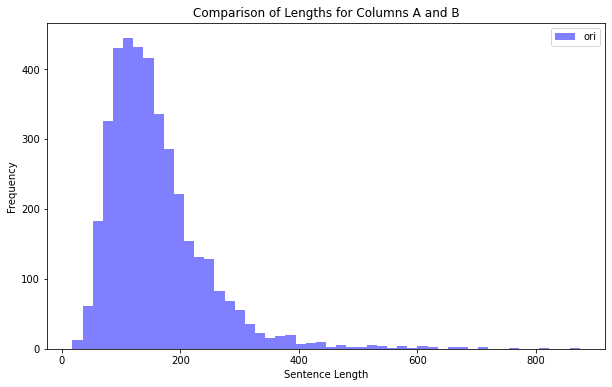

In [476]:
# 줄이기 전 
plt.figure(figsize=(10, 6))
plt.hist(train333['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

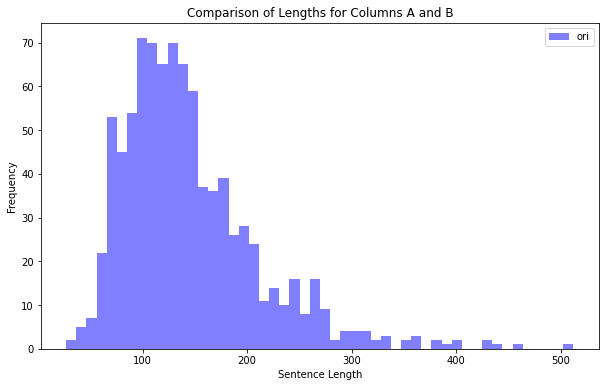

In [451]:
# 줄이기 전 
plt.figure(figsize=(10, 6))
plt.hist(train333[train333['class'].str.contains('협박')]['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

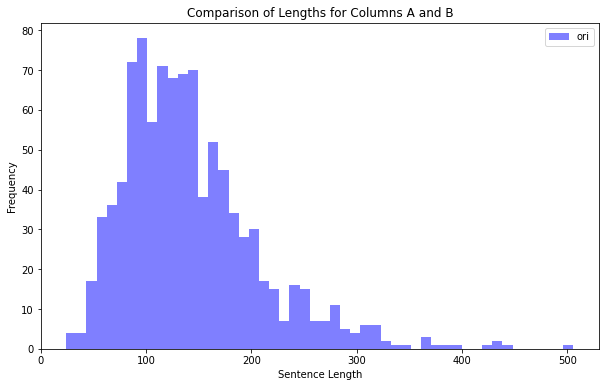

In [452]:
# 줄이기 전 
plt.figure(figsize=(10, 6))
plt.hist(train333[train333['class'].str.contains('직장')]['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

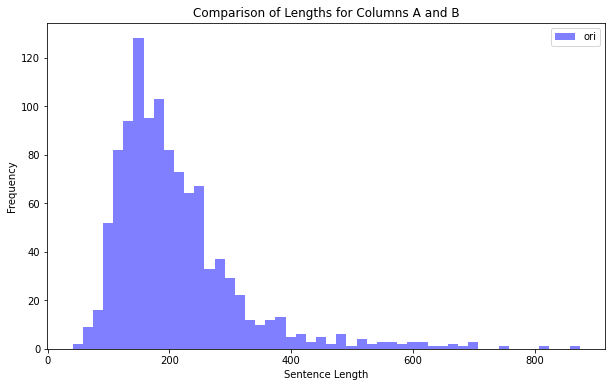

In [477]:
# 줄이기 전 
plt.figure(figsize=(10, 6))
plt.hist(train333[train333['class'].str.contains('기타')]['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

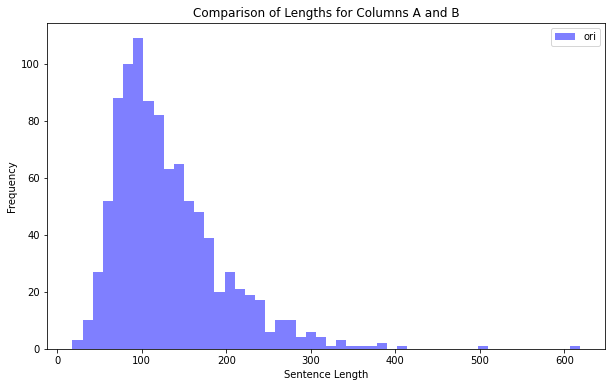

In [454]:
# 줄이기 전 
plt.figure(figsize=(10, 6))
plt.hist(train333[train333['class'].str.contains('갈취')]['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [478]:
train333.to_csv('train_ai_last2.csv')

In [70]:
train_data_path ="./train_ai.csv"
train = pd.read_csv(train_data_path,index_col=0)

In [71]:
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
}
train['class'] = train['class'].map(label_mapping)

In [86]:
train['class'].value_counts()

3    1094
1     981
2     979
0     896
Name: class, dtype: int64

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 클래스 0와 클래스 1의 텍스트 데이터 (예시 데이터)
class_0_data = train[train['class']==3]['conversation'].values
class_1_data = train[train['class']==1]['conversation'].values
class_0_data = class_0_data[:800]
class_1_data = class_1_data[:800]

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=200)
class_0_tfidf = vectorizer.fit_transform(class_0_data)
class_1_tfidf = vectorizer.fit_transform(class_1_data)

# 단어 목록 가져오기
feature_names = vectorizer.get_feature_names_out()

# 두 클래스에서 중복되는 단어 찾기
common_words = set(feature_names[class_0_tfidf.nonzero()[1]]) & set(feature_names[class_1_tfidf.nonzero()[1]])

print("중복되는 단어:", common_words)


중복되는 단어: {'드릴게요', '안녕하세요', '한번만', '그래', '것도', '그래서', '혹시', '하나', '돌려줘', '좋은', '안돼요', '알겠어', '당장', '뒤져서', '내일까지', '그걸', '내놓으라고', '얼마나', '친구', '빌려줘', '어디서', '자꾸', '이제', '그리고', '없어', '빌려주라', '니네', '있어', '돌려줄게', '됐고', '안녕', '그게', '아니에요', '갑자기', '돈을', '아니야', '나한테', '용돈', '너무', '사람', '엄마한테', '알겠습니다', '가방', '없어서', '돌려주세요', '이건', '없어요', '누구세요', '지갑', '당신', '하루만', '미안', '요즘', '고마워', '싫으면', '돈이', '마지막이야', '와봐', '있어요', '제가', '맞고', '뭐야', '이게', '다른', '있는거', '저기', '어떻게', '알겠어요', '지금', '내일', '여기서', '줄게', '안되는데', '돈도', '바로', '없는', '조용히', '아직', '어제', '저기요', '사장님', '없습니다', '오늘', '무슨', '마세요', '네가', '아니', '그렇게', '여기요', '가져와', '알아서', '그러면', '줄래', '없는데요', '너네', '살려주세요', '아니면', '말이야', '같은데', '그런데', '오빠', '내가', '알아', '정말', '말이', '누가', '어이', '왜요', '뭐가', '얼른', '알았어', '없는데', '하는데', '말로', '죄송해요', '그런', '이렇게', '니가', '하고', '너는', '있는', '좋게', '잠깐', '거기', '몰라', '있는데', '나오면', '나는', '그럼', '이거', '그러니까', '꺼져', '엄마가', '쓰고', '하면', '오늘은', '여기', '줘봐', '그래도', '저희', '갚을게', '가지고', '있냐', '나도', '죄송합니다', '친구야', '이러세요', '알지', '돈좀', 

In [30]:
train.head(1)

,idx,class,conversation,conversation2,result
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,A:지금 너 스스로를 죽여달라고 애원하는 것인가?\nB:아닙니다. 죄송합니다.\nA...,"{'Perpetrator': A, 'Victim': B}"


In [8]:
train_data_path ="./data/train.csv"
train = pd.read_csv(train_data_path)

def split_users(x):
    x = x.split('\n')
    userA = x[::2]
    userB = x[1::2]
    return pd.Series(['\n'.join(userA), '\n'.join(userB)], index=['A', 'B'])

train[['A', 'B']] = train['conversation'].apply(split_users)

In [9]:
train

,idx,class,conversation,A,B
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 죽을 거면 혼자 죽지 우리까지 사...,아닙니다. 죄송합니다.\n 정말 잘못했습니다.\n 죄송합니다. 정말 잘못했습니다....
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다.\n네?\n장난전화 걸지 마시죠. \n장난전화는 업무방해죄에 해당됩...,9시 40분 마트에 폭발물을 설치할거다.\n똑바로 들어 한번만 더 얘기한다.\n9시...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n지영아 너가 키 160이지?...,그만해. 니들 놀리는거 재미없어.\n너 군대도 안가고 좋겠다.\n난쟁이들도 장가가고...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기\n너 말이야 너. 이리 오라고\n너 옷 좋아보인다?\n아니에요.돈 없어요...,예??\n무슨 일.\n얘 돈 좀 있나봐\n뒤져서 나오면 넌 죽는다\n콜. 마지막 기...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,아 진짜요? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요!\n음....
...,...,...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,준하야 넌 대가리가 왜이렇게 크냐?\n밥먹으면 대가리만 크냐 너는?\n주위를 둘러봐...,내 머리가 뭐.\n아니. 무슨 머리만 큰다고 그러는거야\n나한테 왜그러는거야.\n넌...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n말로?...,예.? 선생님 진정하시고 우리 말로 해결합시다.\n제발 저희 아들만은 건드리지 말아...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n들리라고 해. 아니...,왜 그래. 들리겠어.\n하긴 그래서 저번에 부장님도.\n그러게.\n나도 그건 못본거...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,누구맘대로 여기서 장사하래?\n남의 구역에서 장사하려면 자릿세를 내야지.\n그거랑 ...,이게 무슨일입니까?\n관청에 신고다하고 적법하게 장사하는 건데 자릿세라뇨?\n못 드...


In [3]:
train_data_path ="./train_ai_last2.csv"
train333 = pd.read_csv(train_data_path,index_col=0)

train333.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 죽을 거면 혼자 죽지 우리까지 사...
1,1,협박 대화,9시 40분 마트에 폭발물을 설치할거다.\n똑바로 들어 한번만 더 얘기한다.\n9시...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,예??\n무슨 일.\n얘 돈 좀 있나봐\n뒤져서 나오면 넌 죽는다\n콜. 마지막 기...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
}
train333['class'] = train333['class'].map(label_mapping)

In [5]:
train333['class'].value_counts()

3    1094
1     981
2     979
0     896
Name: class, dtype: int64

In [6]:
5e-5 == 0.00005

True

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 클래스 0와 클래스 1의 텍스트 데이터 (예시 데이터)
class_0_data = train333[train333['class']==3]['conversation'].values
class_1_data = train333[train333['class']==0]['conversation'].values
class_0_data = class_0_data[:800]
class_1_data = class_1_data[:800]

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=800)
class_0_tfidf = vectorizer.fit_transform(class_0_data)
class_1_tfidf = vectorizer.fit_transform(class_1_data)

# 단어 목록 가져오기
feature_names = vectorizer.get_feature_names_out()

# 두 클래스에서 중복되는 단어 찾기
common_words = set(feature_names[class_0_tfidf.nonzero()[1]]) & set(feature_names[class_1_tfidf.nonzero()[1]])

print("중복되는 단어:", common_words)


중복되는 단어: {'부탁이야', '말로', '봐서', '오빠가', '무서워', '선생님', '그동안', '대신', '이번', '대체', '아무', '죽일거야', '되는', '그러면', '기어오르네', '너만', '핸드폰', '때까지', '이렇게', '딸도', '이거', '이상', '한번만', '아까', '쳐맞고', '경찰에', '믿어', '기분', '차를', '생각이', '시키는대로', '미쳤냐', '못차렸네', '일주일', '뽑아', '안주면', '얼마나', '엄마', '있는거', '이런', '해서', '하고', '알바', '죽은', '딸이', '되는지', '해라', '내일', '자네', '같은데', '오랜만이다', '어디에', '서로', '똑똑히', '똑바로', '새끼가', '뭐야', '그것도', '보이지', '니들', '말도', '니가', '닥쳐', '세상에', '말은', '듣고', '받은', '알겠어', '잡아', '하네', '가족들', '약속', '싫은데', '뭐가', '않아', '그니까', '같은', '알아들어', '안그러면', '살지', '무사할', '누구', '할거야', '하나는', '이리', '자네가', '할게', '할때', '맨날', '말했지', '오면', '여기서', '데리고', '간다', '무사하지', '칼로', '있다고', '나를', '자꾸', '나갈', '장기', '아직', '그럼', '있습니다', '일로와', '기다려', '안하지', '하지말고', '안돼', '사람', '거기', '보여', '아니고', '얼굴', '이유가', '없잖아', '마지막으로', '김사장', '여기에', '사진', '어디야', '일이', '아니긴', '어서', '가족이', '계속', '싶어', '개새끼야', '조심해', '말할거야', '누가', '살고', '없지', '없다고', '언제', '어때', '지키면', '죽이는', '말만', '싫다고', '싶으면', '아들', '기다리고', '한테', '새끼', '애가', '동생', '회사', '알았어', '됐네', 

In [8]:
train333.head(1)

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 죽을 거면 혼자 죽지 우리까지 사...


In [9]:
train333['conversation'] = train333[['class','conversation']].apply(lambda x : x[1].replace('돈','') if x[0] == 3 else x[1], axis=1)

for i , (c,texts) in enumerate(zip(train333['class'], train333['conversation'])):
    if c == 0 :
        for text in texts.split('\n'):
            if text.find('살려') != -1 :
                
                print(i, c)
                print(text)

                print('-'*50)

71 0
네 살려주세요
--------------------------------------------------
98 0
살려줄게 살려주는 대신에 한 명에 니 장기 하나 어때?
--------------------------------------------------
349 0
살려쥐세요 제발
--------------------------------------------------
436 0
 웃기네 되도않는 전통타령 그만해. 그게 뭐라고 남의 인생을 짓밟는거야. 너도 똑같이 당해봐 너 같은 쓰레기를 낳은 니 부모 먼저 되봐야 너도 정신을 차리지. 살려 하지마. 걍 가만히 찌그러져 있어.
--------------------------------------------------
472 0
얌전히 있으면 목숨은 살려줄게
--------------------------------------------------
803 0
입은 살려 놓아야지
--------------------------------------------------
828 0
그래 잘한 선택이야 가족은 살려주지
--------------------------------------------------
884 0
아 제발 살려주세요.
--------------------------------------------------
884 0
내가 너희 동생을 살려줄게 대신 너의 장기를 주면 돼 어때?
--------------------------------------------------
1007 0
싫은데 살려주면 신고 할거잖아
--------------------------------------------------
1010 0
다 제가 잘못 했습니다. 제 아들 만큼은 살려주세요
--------------------------------------------------
1021 0
이제 와서 ? 내 얼굴을 다 본 너를 어떻게 믿고 살려놔? 어차피 목격자는 너 하나고 그 목격자가 세상에서 없어지는게 

In [10]:
!pip install -q googletrans==4.0.0rc1

In [11]:
import googletrans

In [12]:
translator = googletrans.Translator()

In [ ]:
# trans = list()
# for idx, i in enumerate(train333['conversation']):
#     if idx % 100 == 0:
#         print(idx)
#     tran =list()
#     for text in i.split('\n'):
#         try :
#             text_en = translator.translate(text, dest='en', src='ko')
#             text_ko = translator.translate(text_en.text, dest='ko', src='en')
#             tran.append(text_ko.text)
#         except:
#             pass
#     trans.append('\n'.join(tran))
    
# trans

0
